# Data Visualization

In [1]:
# global imports
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import ttest_ind
# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# pyspark
import findspark
findspark.init()
import pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as W

spark = SparkSession.builder.getOrCreate()
# specifications for visualizations
plt.style.use('seaborn')

# Import Data

In [2]:
# import data
%store -r dfs

In [3]:
# import eda data
eda_df = spark.createDataFrame(dfs[2])
# output data frame
eda_df.show(2)

+-----------+-----+-------------------+--------------------+------+
|  variation|label|               date|          text_clean|length|
+-----------+-----+-------------------+--------------------+------+
|      Black|    0|2018-06-11 00:00:00|Love my Alexa Ech...|    66|
|Black  Plus|    0|2018-07-30 00:00:00|Not that much dif...|    58|
+-----------+-----+-------------------+--------------------+------+
only showing top 2 rows



In [4]:
# import vocabulary
vocab = dfs[3]

# Single Variable EDA

## `label` Variable

In [5]:
# levels of label
eda_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 1623|
|    1|  148|
+-----+-----+



This is an imbalanced classification problem since most of the observations are positive reviews.

## `text_clean` Variable

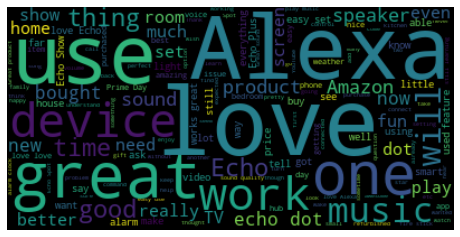

In [6]:
# create an RDD of the tweets
reviews_lst = eda_df.select('text_clean').rdd.flatMap(lambda row:row).collect()
# create a string of all of the tweets
reviews = ''
for review in reviews_lst:
    reviews += review
# create a word cloud
wordcloud = WordCloud().generate(reviews)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

The word cloud shows common terms in reviews include "love," "Alexa," and "use." This is expected given that the data is reviews of Amazon Alexa products, and most of these reviews are positive.

## `length` Variable

In [7]:
# summary statistics
eda_df.describe('length').show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|              1771|
|   mean|26.591756070016938|
| stddev| 36.47695534145185|
|    min|                 1|
|    max|               471|
+-------+------------------+



The distribution review lengths is very spread out since there is a large range and standard deviation. 

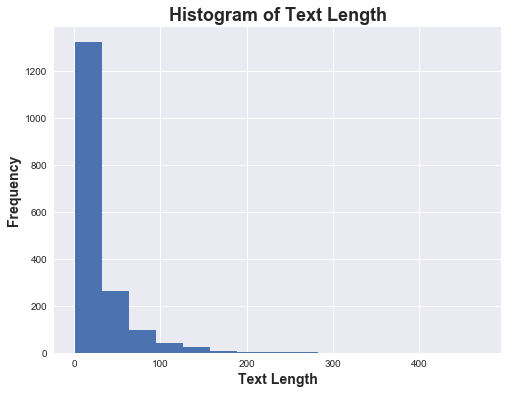

In [8]:
# create a list of the lengths
lengths_lst = list(eda_df.select('length').rdd.flatMap(lambda row:row).collect())
# create a histogram of text length
plt.figure(figsize=(8,6))
plt.hist(lengths_lst,bins=15)
plt.xlabel('Text Length',fontsize=14,weight='bold')
plt.ylabel('Frequency',fontsize=14,weight='bold')
plt.title('Histogram of Text Length',fontsize=18,weight='bold')
plt.show()

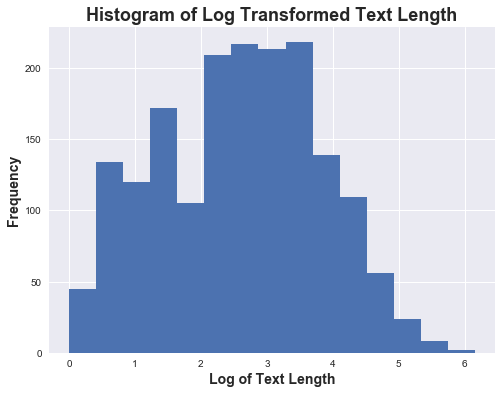

In [9]:
# create a histogram of text length
plt.figure(figsize=(8,6))
plt.hist(np.log(lengths_lst),bins=15)
plt.xlabel('Log of Text Length',fontsize=14,weight='bold')
plt.ylabel('Frequency',fontsize=14,weight='bold')
plt.title('Histogram of Log Transformed Text Length',fontsize=18,weight='bold')
plt.show()

The histogram of Text length shows that the data is skewed to the right. When looking at the hisogram of the log of text length, the data is roughly symmetric. In future visualizations, I will look at the log of text length since this visualization is easier to view.

## `variation` Variable

In [10]:
# levels of variation
var = eda_df.groupby('variation').count()
var.show(truncate=False)

+----------------------------+-----+
|variation                   |count|
+----------------------------+-----+
|Heather Gray Fabric         |65   |
|Black  Dot                  |205  |
|Oak Finish                  |7    |
|Configuration: Fire TV Stick|230  |
|Sandstone Fabric            |36   |
|White  Show                 |63   |
|White  Plus                 |58   |
|White  Spot                 |68   |
|Black  Spot                 |159  |
|Black  Show                 |181  |
|Walnut Finish               |4    |
|White                       |65   |
|Charcoal Fabric             |193  |
|White  Dot                  |84   |
|Black  Plus                 |177  |
|Black                       |176  |
+----------------------------+-----+



In [11]:
# order the list of variation and count
var_lst = list(var.select('variation').rdd.flatMap(lambda row:row).collect())
count_lst = list(var.select('count').rdd.flatMap(lambda row:row).collect())
var_zipped = zip(count_lst,var_lst)
var_sort = sorted(var_zipped)
var_sort_lst = [var_sort[i][1] for i in range(len(var_sort))]
count_sort_lst = [var_sort[i][0] for i in range(len(var_sort))]

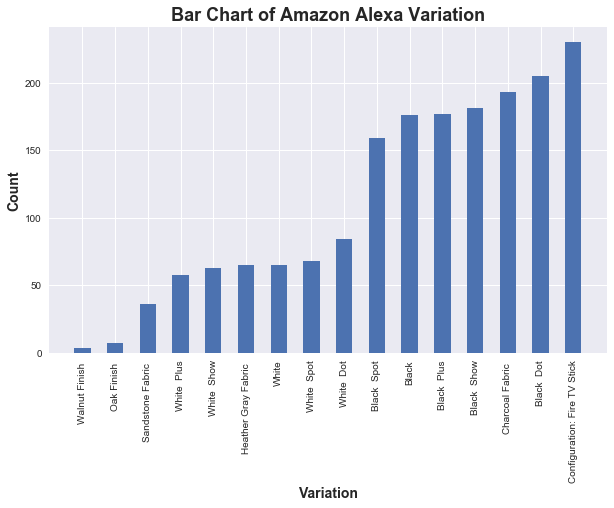

In [12]:
# create bar chart
x = np.arange(len(var_sort_lst))
# create bar chart
plt.figure(figsize=(10,6))
plt.bar(x,count_sort_lst,width=0.5)
# set tick marks
plt.xticks(x,var_sort_lst, rotation='90')
# create labels
plt.xlabel('Variation',fontsize=14,weight='bold')
plt.ylabel('Count',fontsize=14,weight='bold')
plt.title('Bar Chart of Amazon Alexa Variation',fontsize=18,weight='bold')
plt.show()

The number of reviews varies greatly amongst different variations of Amazon Alexas.

## `date` Variable

In [13]:
# crete dates data frame
dates_df = eda_df.groupby('date').count().sort('date')
dates_df.show(2)

+-------------------+-----+
|               date|count|
+-------------------+-----+
|2018-05-16 00:00:00|    4|
|2018-05-17 00:00:00|    4|
+-------------------+-----+
only showing top 2 rows



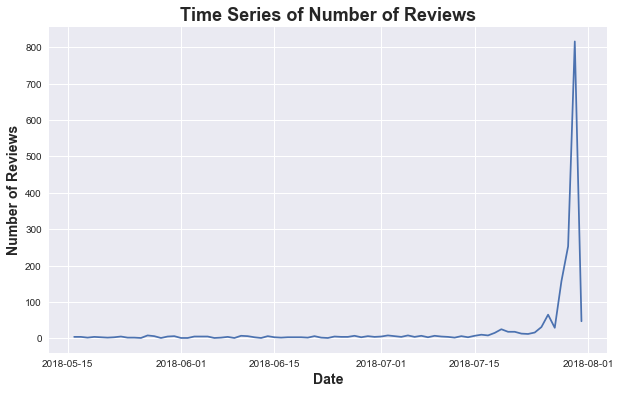

In [14]:
# create list of dates and count
dates_lst = list(dates_df.select('date').rdd.flatMap(lambda row:row).collect())
counts_lst = list(dates_df.select('count').rdd.flatMap(lambda row:row).collect())
# create time series plot
plt.figure(figsize=(10,6))
plt.plot(dates_lst,counts_lst)
plt.xlabel('Date',fontsize=14,weight='bold')
plt.ylabel('Number of Reviews',fontsize=14,weight='bold')
plt.title('Time Series of Number of Reviews',fontsize=18,weight='bold')
plt.show()

In [15]:
# output date that many observations come from
dates_df.where(W.col('count')>400).show()

+-------------------+-----+
|               date|count|
+-------------------+-----+
|2018-07-30 00:00:00|  816|
+-------------------+-----+



Many reviews come from the last view days of July. 7/30/2018 has the largest number of reviews for a single day.

# Multiple Variables EDA

## `length` and `label`

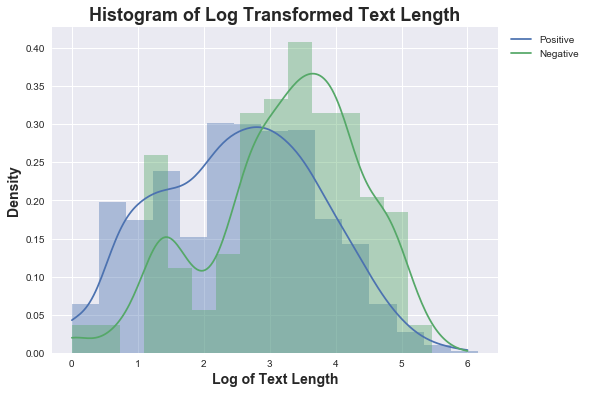

In [16]:
# create lists
pos_lengths_lst = list(eda_df.select('length').where(W.col('label')==0).rdd.flatMap(lambda row:row).collect())
neg_lengths_lst = list(eda_df.select('length').where(W.col('label')==1).rdd.flatMap(lambda row:row).collect())
# obtain density
xs = np.linspace(0,6,200)
pos_density = gaussian_kde(np.log(pos_lengths_lst))
pos_density.covariance_factor = lambda : .25
pos_density._compute_covariance()
neg_density = gaussian_kde(np.log(neg_lengths_lst))
neg_density.covariance_factor = lambda : .25
neg_density._compute_covariance()
# create a histogram of text length by label
plt.figure(figsize=(8,6))
plt.hist(np.log(pos_lengths_lst),bins=15,density=True,alpha=0.4)
plt.hist(np.log(neg_lengths_lst),bins=15,density=True,alpha=0.4)
plt.plot(xs,pos_density(xs),color='C0')
plt.plot(xs,neg_density(xs),color='C1')
plt.xlabel('Log of Text Length',fontsize=14,weight='bold')
plt.ylabel('Density',fontsize=14,weight='bold')
plt.title('Histogram of Log Transformed Text Length',fontsize=18,weight='bold')
# create legend
plt.legend(['Positive','Negative'],bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.show()

The distribution of negative reviews seems to have slightly larger log transformed review lengths comparted to the distribution of positive reviews. 

In [17]:
# run t test on the data
stat,p = ttest_ind(np.log(pos_lengths_lst),np.log(neg_lengths_lst))
if p < 0.05:
    print('Statistically Significant')
else:
    print ('Not Statistically Significant')

Statistically Significant


Since the p value is less than alpha=0.05, I have statistically significant evidence to say that the distribution of the log of positive review lengths differs from the distribution of the log of negative review lengths.

## `variation` and `label`

In [18]:
# create data frame of counts for variation and label
var_lab_df = eda_df.groupby('label','variation').count()
# output data frame
var_lab_df.show(2)

+-----+----------------+-----+
|label|       variation|count|
+-----+----------------+-----+
|    0|     Oak Finish |    7|
|    1|Charcoal Fabric |    7|
+-----+----------------+-----+
only showing top 2 rows



In [19]:
# create data frame for counts of positive reviews
pos_var_lab_df = var_lab_df.where(W.col('label') == 0).sort('variation')
pos_var_lab_df = pos_var_lab_df.withColumnRenamed('count','pos_count')
pos_var_lab_df = pos_var_lab_df.drop('label')
pos_var_lab_df.show(2)

+----------+---------+
| variation|pos_count|
+----------+---------+
|     Black|      152|
|Black  Dot|      191|
+----------+---------+
only showing top 2 rows



In [20]:
# create data frame for counts of negative reviews
neg_var_lab_df = var_lab_df.where(W.col('label') == 1).sort('variation')
neg_var_lab_df = neg_var_lab_df.withColumnRenamed('count','neg_count')
neg_var_lab_df = neg_var_lab_df.withColumnRenamed('variation','variation2')
neg_var_lab_df = neg_var_lab_df.drop('label')
neg_var_lab_df.show(2)

+----------+---------+
|variation2|neg_count|
+----------+---------+
|     Black|       24|
|Black  Dot|       14|
+----------+---------+
only showing top 2 rows



In [21]:
# create data frame for proportions
prop_var_lab_df = pos_var_lab_df.join(neg_var_lab_df,(pos_var_lab_df.variation==neg_var_lab_df.variation2))
prop_var_lab_df = prop_var_lab_df.withColumn('count',W.col('pos_count')+W.col('neg_count'))
prop_var_lab_df = prop_var_lab_df.withColumn('pos_prop',W.col('pos_count')/W.col('count'))
prop_var_lab_df = prop_var_lab_df.withColumn('neg_prop',W.col('neg_count')/W.col('count'))
prop_var_lab_df.show(2)

+--------------------+---------+--------------------+---------+-----+------------------+-------------------+
|           variation|pos_count|          variation2|neg_count|count|          pos_prop|           neg_prop|
+--------------------+---------+--------------------+---------+-----+------------------+-------------------+
|Heather Gray Fabric |       63|Heather Gray Fabric |        2|   65|0.9692307692307692|0.03076923076923077|
|          Black  Dot|      191|          Black  Dot|       14|  205|0.9317073170731708|0.06829268292682927|
+--------------------+---------+--------------------+---------+-----+------------------+-------------------+
only showing top 2 rows



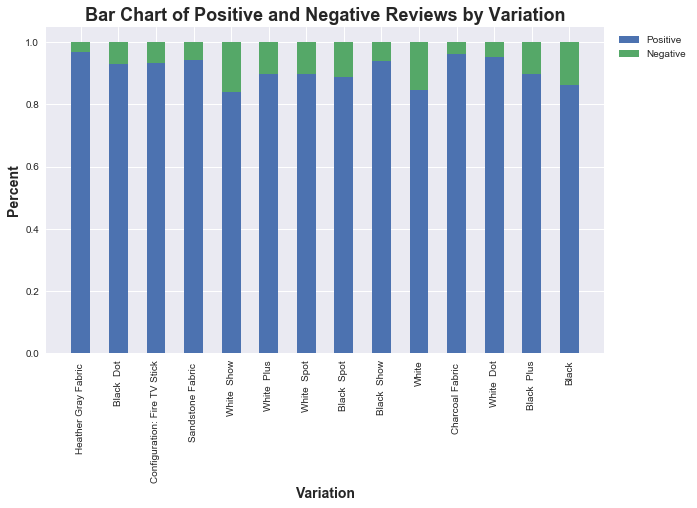

In [22]:
# create bar chart for proportions of positive and negative reviews
labels = prop_var_lab_df.select('variation').rdd.map(lambda row:row[0]).collect()
x = np.arange(len(labels))
pos_prop_lst = prop_var_lab_df.select('pos_prop').rdd.map(lambda row:row[0]).collect()
# create bar chart
plt.figure(figsize=(10,6))
plt.bar(x,pos_prop_lst,width=0.5)
plt.bar(x,prop_var_lab_df.select('neg_prop').rdd.map(lambda row:row[0]).collect(),bottom=pos_prop_lst,width=0.5)
# set tick marks
plt.xticks(x,labels, rotation='90')
# create labels
plt.xlabel('Variation',fontsize=14,weight='bold')
plt.ylabel('Percent',fontsize=14,weight='bold')
plt.title('Bar Chart of Positive and Negative Reviews by Variation',fontsize=18,weight='bold')
# create legend
plt.legend(['Positive','Negative'],bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.show()

The amount of percentage of positive and negative reviews is roughly the same for each variation.

## `variation` and `date`

In [23]:
# crete dates data frame
var_dates_df = eda_df.groupby('variation','date').count().sort('date')
var_dates_df.show(2)

+---------+-------------------+-----+
|variation|               date|count|
+---------+-------------------+-----+
|    Black|2018-05-16 00:00:00|    4|
|    Black|2018-05-17 00:00:00|    3|
+---------+-------------------+-----+
only showing top 2 rows



In [24]:
# output number of days that reviews were taken from
var_dates_gb = var_dates_df.groupby('variation').count()
var_dates_gb.show(truncate=False)

+----------------------------+-----+
|variation                   |count|
+----------------------------+-----+
|Heather Gray Fabric         |3    |
|Black  Dot                  |3    |
|Oak Finish                  |1    |
|Configuration: Fire TV Stick|2    |
|Sandstone Fabric            |3    |
|White  Show                 |4    |
|White  Plus                 |23   |
|White  Spot                 |16   |
|Black  Spot                 |17   |
|Black  Show                 |4    |
|Walnut Finish               |2    |
|White                       |46   |
|Charcoal Fabric             |4    |
|White  Dot                  |2    |
|Black  Plus                 |28   |
|Black                       |69   |
+----------------------------+-----+



Reviews for some variations of Amazon Alexas, like "Black," are scattered over many days. Other variations, like "Oak Finsih" are confined to a few days.

In [25]:
# see which variations have observations from dates before 7/28/18
var_dates_df.where(W.col('date')<'2018-07-28').groupby('variation').count().show()

+-----------+-----+
|  variation|count|
+-----------+-----+
|White  Plus|   20|
|White  Spot|   12|
|Black  Spot|   13|
|      White|   43|
|Black  Plus|   24|
|      Black|   65|
+-----------+-----+



Also, only a few variations of Amazon Alexas have reviews from dates before 7/28/2018.

In [26]:
# create data frame for the average number of reviews per day by variation
var_dates_gb = var_dates_gb.withColumnRenamed('variation','variation2')
var_dates_gb = var_dates_gb.withColumnRenamed('count','count_date')
avg_var_dates = var_dates_gb.join(var,var_dates_gb.variation2 == var.variation)
avg_var_dates = avg_var_dates.drop('variation2')
avg_var_dates = avg_var_dates.withColumn('avg_per_day',W.col('count')/W.col('count_date'))
avg_var_dates.show()

+----------+--------------------+-----+------------------+
|count_date|           variation|count|       avg_per_day|
+----------+--------------------+-----+------------------+
|         3|Heather Gray Fabric |   65|21.666666666666668|
|         3|          Black  Dot|  205| 68.33333333333333|
|         1|         Oak Finish |    7|               7.0|
|         2|Configuration: Fi...|  230|             115.0|
|         3|   Sandstone Fabric |   36|              12.0|
|         4|         White  Show|   63|             15.75|
|        23|         White  Plus|   58|2.5217391304347827|
|        16|         White  Spot|   68|              4.25|
|        17|         Black  Spot|  159| 9.352941176470589|
|         4|         Black  Show|  181|             45.25|
|         2|      Walnut Finish |    4|               2.0|
|        46|               White|   65|1.4130434782608696|
|         4|    Charcoal Fabric |  193|             48.25|
|         2|          White  Dot|   84|              42.

In [27]:
# order the list of variation and count
avg_var_lst = list(avg_var_dates.select('variation').rdd.flatMap(lambda row:row).collect())
avg_count_lst = list(avg_var_dates.select('avg_per_day').rdd.flatMap(lambda row:row).collect())
avg_var_zipped = zip(avg_count_lst,avg_var_lst)
avg_var_sort = sorted(avg_var_zipped)
avg_var_sort_lst = [avg_var_sort[i][1] for i in range(len(avg_var_sort))]
avg_count_sort_lst = [avg_var_sort[i][0] for i in range(len(avg_var_sort))]

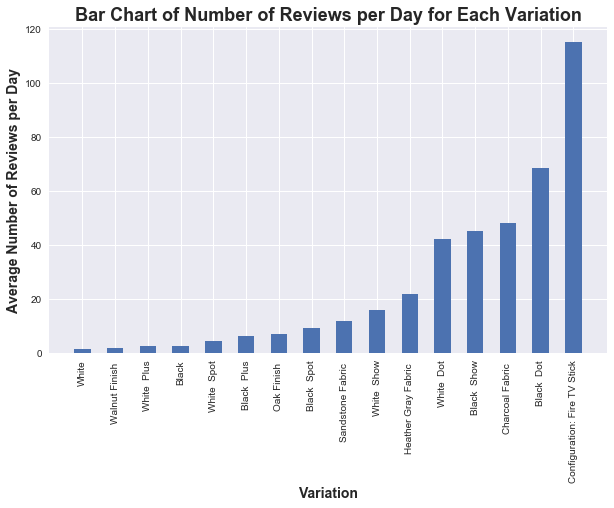

In [28]:
# create bar chart
x = np.arange(len(avg_var_sort_lst))
# create bar chart
plt.figure(figsize=(10,6))
plt.bar(x,avg_count_sort_lst,width=0.5)
# set tick marks
plt.xticks(x,avg_var_sort_lst, rotation='90')
# create labels
plt.xlabel('Variation',fontsize=14,weight='bold')
plt.ylabel('Average Number of Reviews per Day',fontsize=14,weight='bold')
plt.title('Bar Chart of Number of Reviews per Day for Each Variation',fontsize=18,weight='bold')
plt.show()

The average number of reviews per day varies greatly depending on the variation of Amazon Alexa for this dataset.